# ICEBERG structural elucidation demo with candidates from PubChem
This notebook serves as a demo that applies ICEBERG to structural elucidation with candidates from PubChem. You should feel free to change the data and configurations to your own setting.

In [1]:
%load_ext autoreload
%autoreload 2

import copy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import ms_pred.common as common
from ms_pred.dag_pred.iceberg_elucidation import candidates_from_pubchem, iceberg_prediction, load_real_spec, load_pred_spec, elucidation_over_candidates, plot_top_mols, explain_peaks, modi_finder, load_global_config

/home/roger/miniforge3/envs/ms-main/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%cd ~/ms-pred

/mnt/c/Users/runzh/OneDrive/Documents/2023/ms-pred


## Global configs
Please modify the configs in `configs/iceberg/iceberg_elucidation.yaml` accordingly. If your hostname is ``server1``, create a new entry named ``server1``, and specify all the parameters as shown in the example.

In [3]:
config = load_global_config()

## Specify configurations
If there's something specific to change in the global configuration, please specify here

In [4]:
local_config = copy.deepcopy(config)
local_config['nce'] = True  # nce is used instead of eV values in the MS/MS file for collision energy
local_config['merge_spec'] = True  # merge spec for visualization

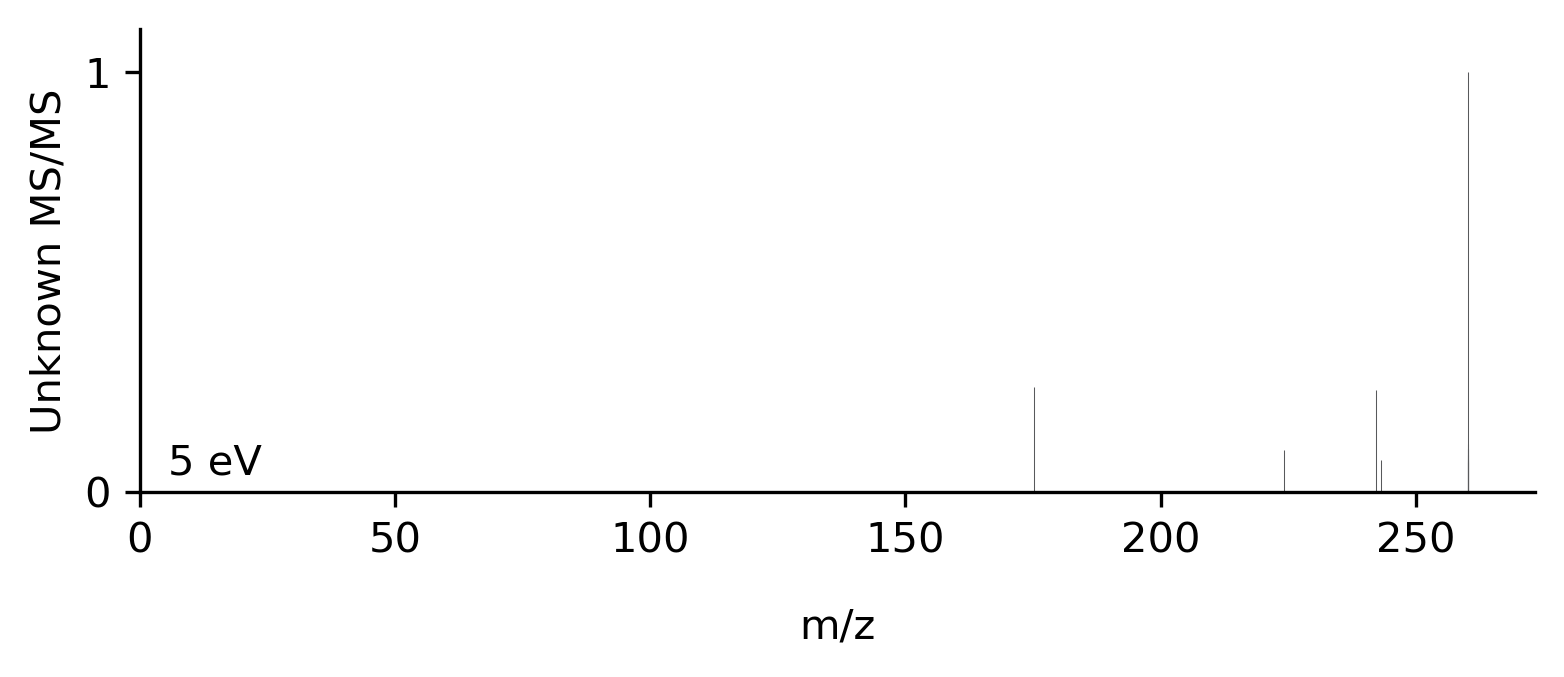

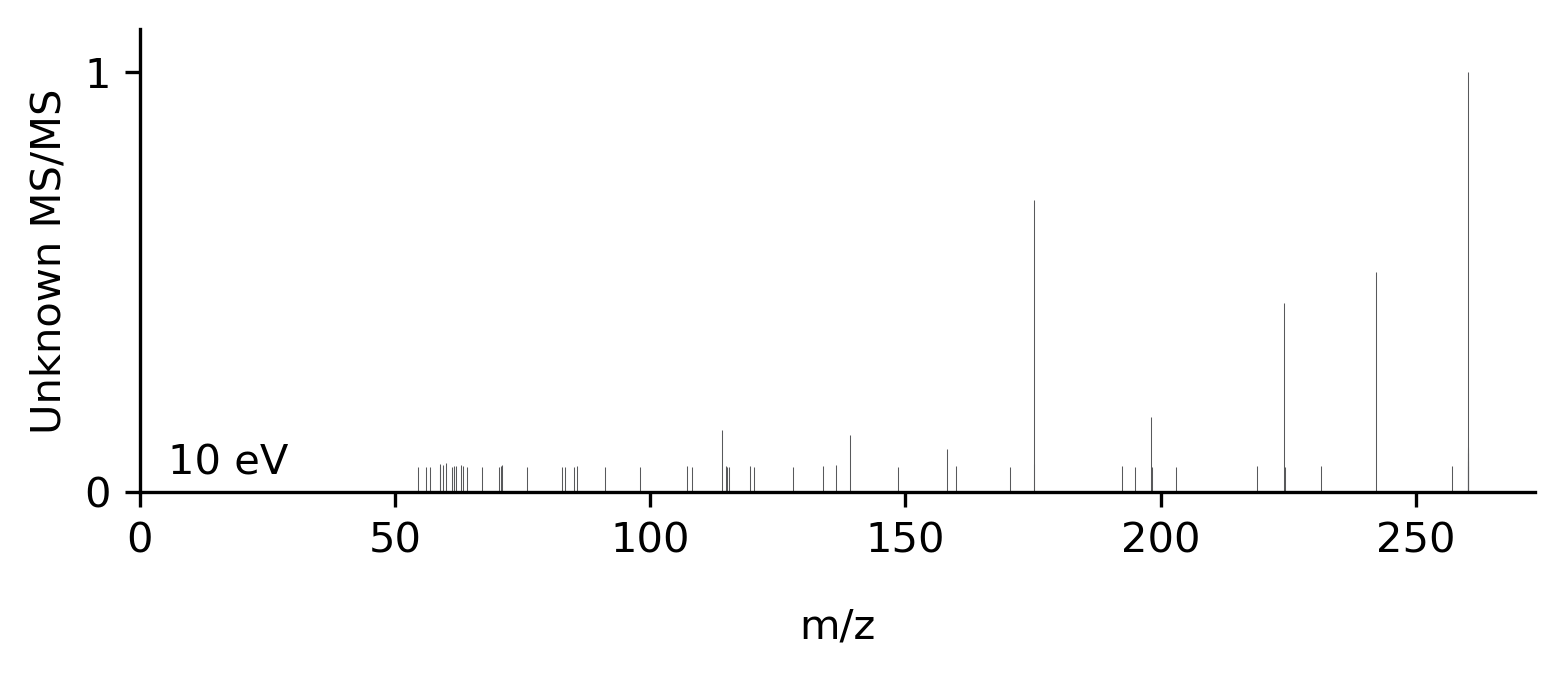

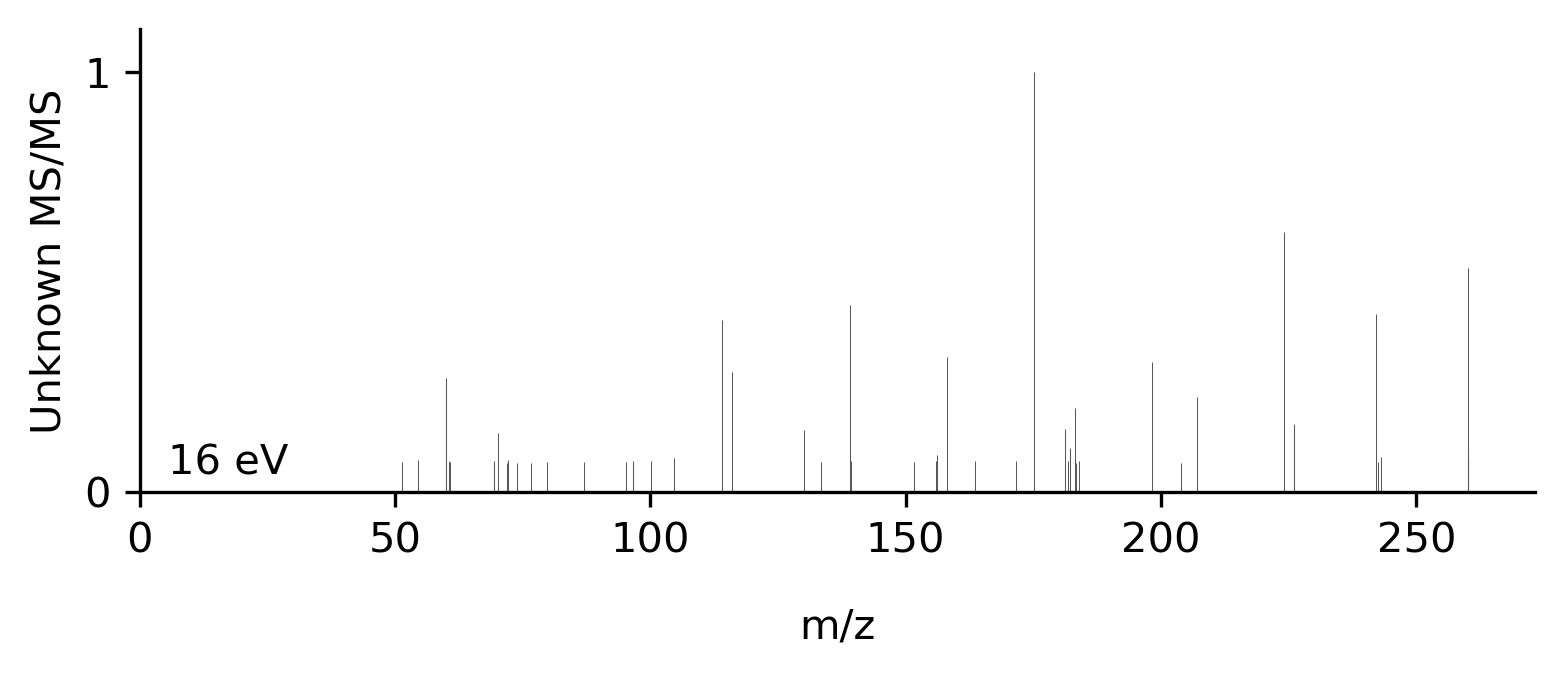

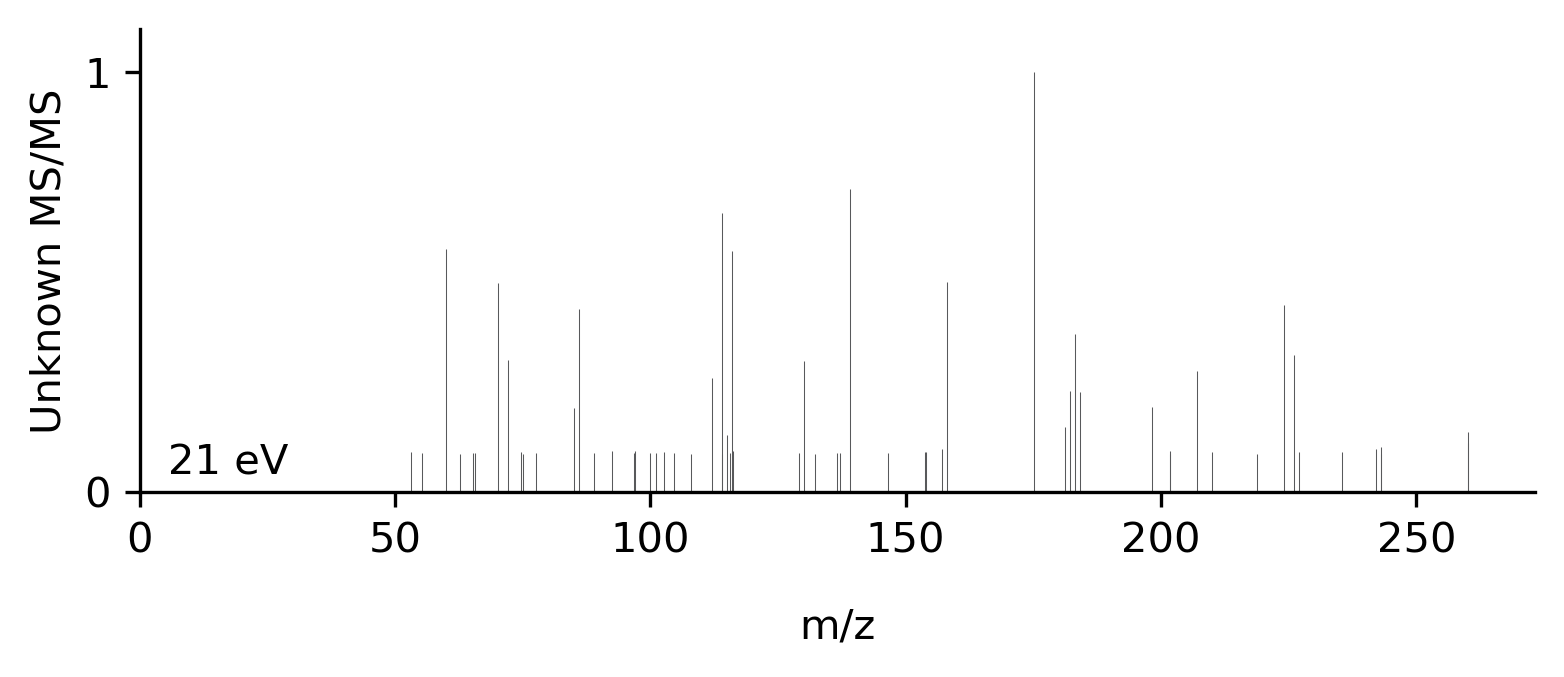

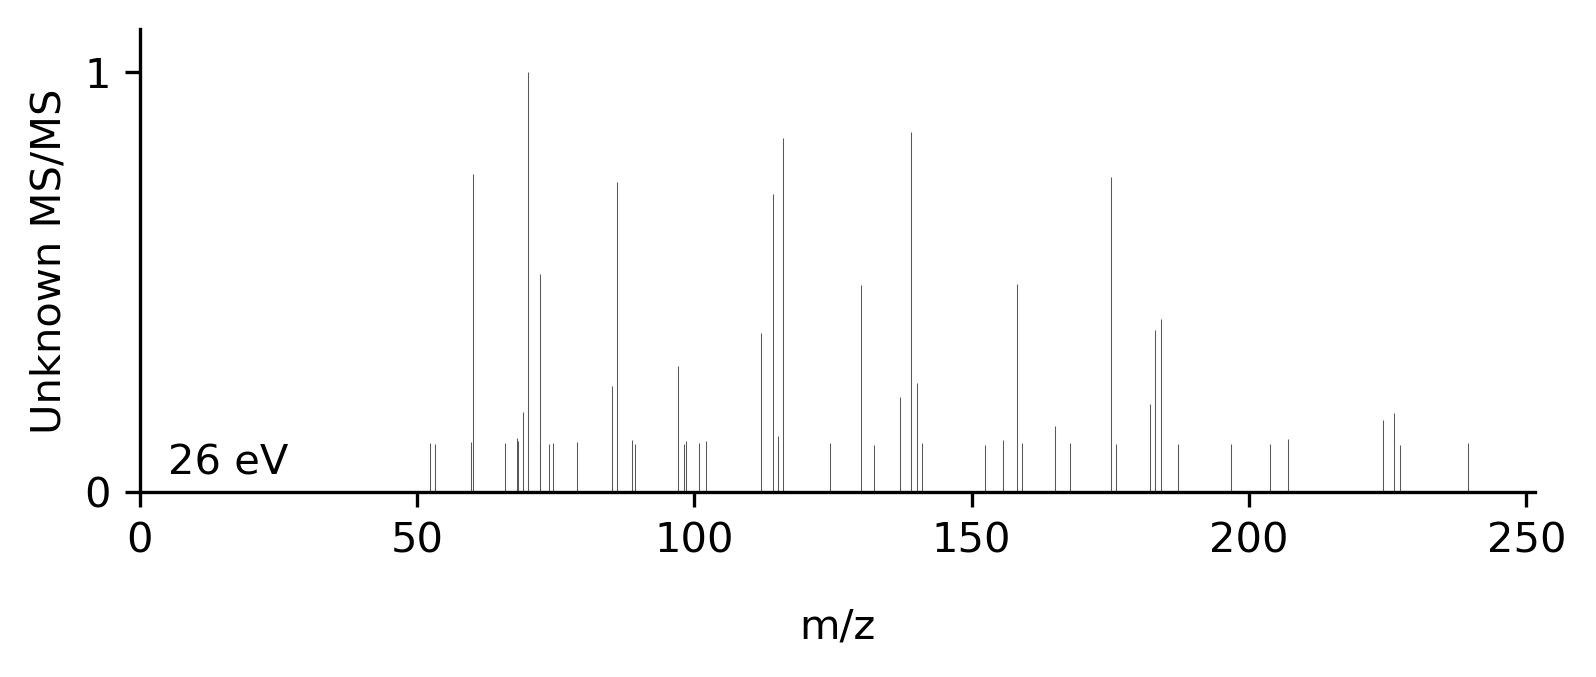

In [5]:
unknown_spec_path = 'data/exp_specs/clinical/csf_unknown.ms'
unknown_spec = load_real_spec(unknown_spec_path, real_spec_type='ms', **local_config)
# unknown_spec is a dictionary:
#   collision_energy_1: spec (2d-array)
#   collision_energy_2: spec (2d-array)
#   ...
for ce, spec in unknown_spec.items():
    common.plot_ms(spec, 'Unknown MS/MS', f'{ce} eV')

## Get candidates

In [6]:
smiles = candidates_from_pubchem('C10H21N5O3')
f'number of candidates {len(smiles)}'

'number of candidates 60'

## Run ICEBERG prediction
The following line of code will generate a .tsv for all candidates and call ``pred_smis.py``. All intermediate results will be cached in your temporary directory (``result_path``). If the same task has been run before, the cached result will be loaded.

In [7]:
result_path, pmz = iceberg_prediction(smiles, [10, 20, 30, 40, 50], adduct='[M+H]+', **local_config)

## Rank candidates by entropy similarity

[CSF unknown] Found target mol at 1/60, ent_dist=0.503


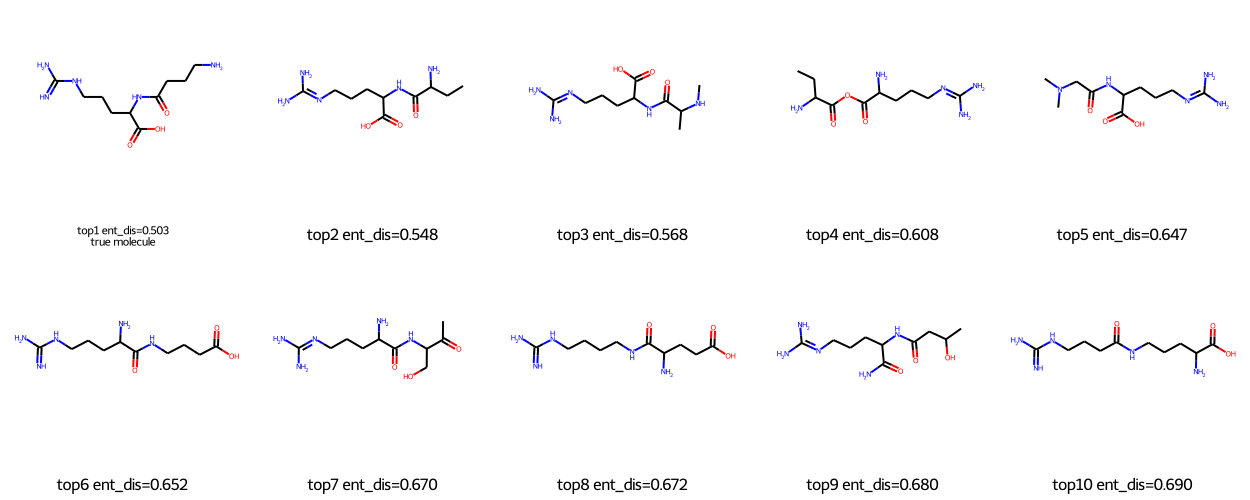

In [8]:
# if you already know the real smiles, you can specify it here (retrospective). Otherwise, it could be None
real_smi = r'C(C[C@@H](C(=O)O)NC(=O)CCCN)CN=C(N)N'

# Compare spectrum similarity for elucidation
topk_results = elucidation_over_candidates(result_path, unknown_spec_path, precursor_mass=pmz, mol_name="CSF unknown", real_smiles=real_smi, **local_config)

# Plot top results
img = plot_top_mols(topk_results)
img

## Visualize and compare ICEBERG predictions
Peaks marked by green are matched by 5ppm, and the ICEBERG-predicted fragment structures and m/z values are visualized. You can check manually if the structure is a reasonable match to the spectrum of unknown. The spectra are merged from 5 collision energies when plotting (you can also plot them separately by setting ``merge_spec=False`` in config).

In [9]:
def visualize_compare_preds(top_i):
    plt.figure(figsize=(3, 2), dpi=400)
    fig = explain_peaks(result_path, unknown_spec_path, pmz, topk_results[top_i][0], num_peaks=9, axes=plt.gca(), **local_config)
    plt.title(f'entropy similarity={1-topk_results[top_i][1]:.2f}')

## Top-1 prediction

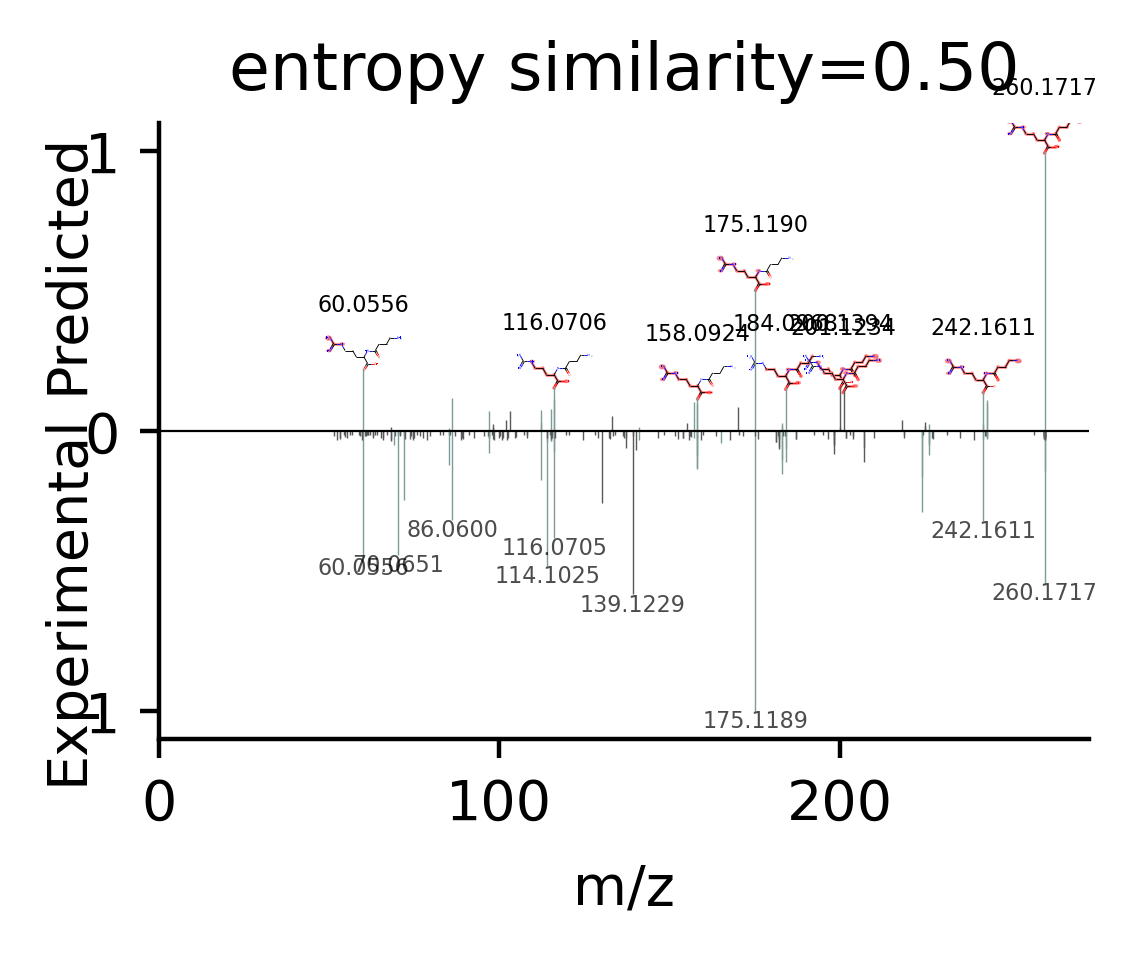

In [10]:
visualize_compare_preds(0)  # index starts at 0

## Top-2 prediction

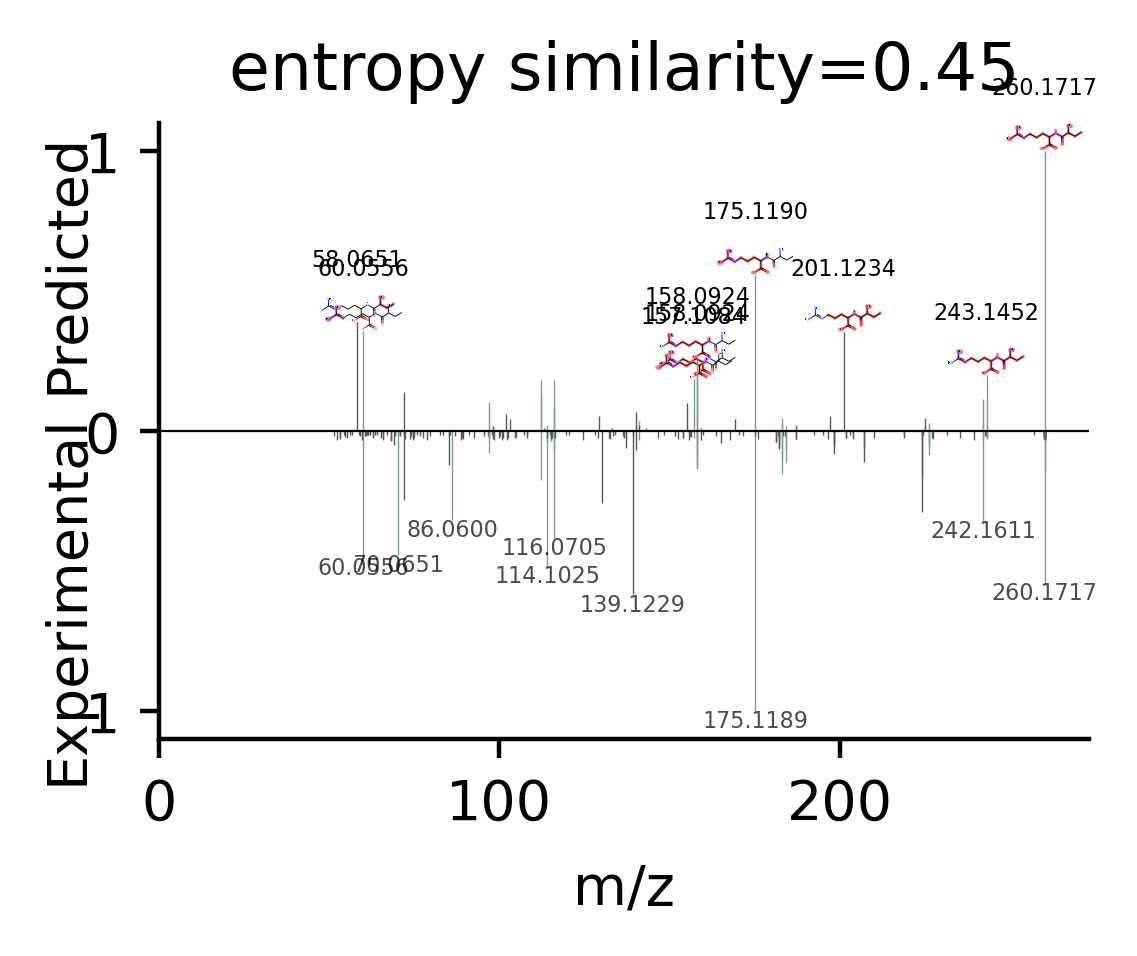

In [11]:
visualize_compare_preds(1)

## Top-3 prediction

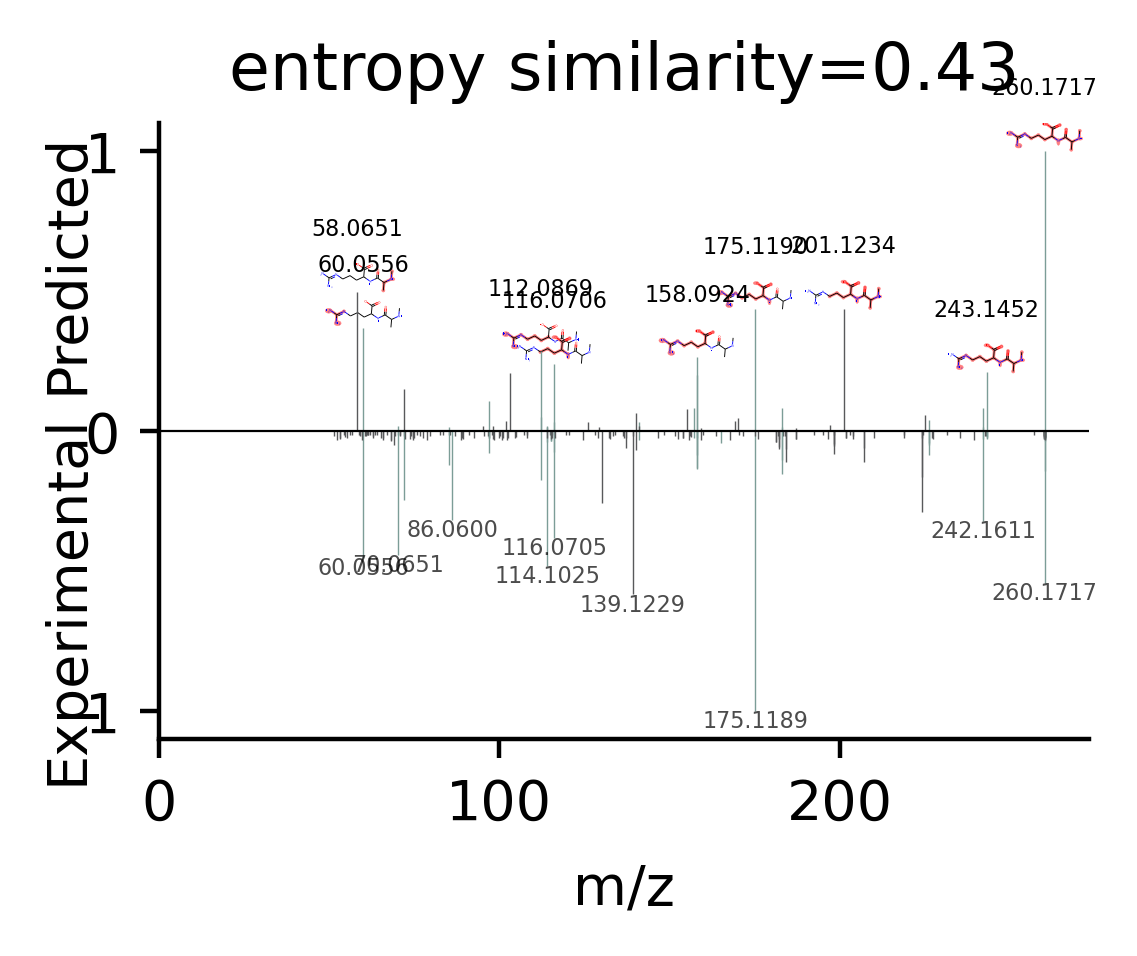

In [12]:
visualize_compare_preds(2)